# Estación Escuelas Aguirre

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from itertools import product

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [4]:
df = pd.read_csv("../data/df_8.csv", index_col=0)
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,NO2
month,
2013-01-01,33.516129
2013-02-01,40.290323
2013-03-01,36.548387
2013-04-01,31.548387
2013-05-01,32.612903


### Estacionalidad

In [6]:
df2 = df.copy()

In [7]:
df2["año"] = df.index.year
df2["mes"] = df.index.month

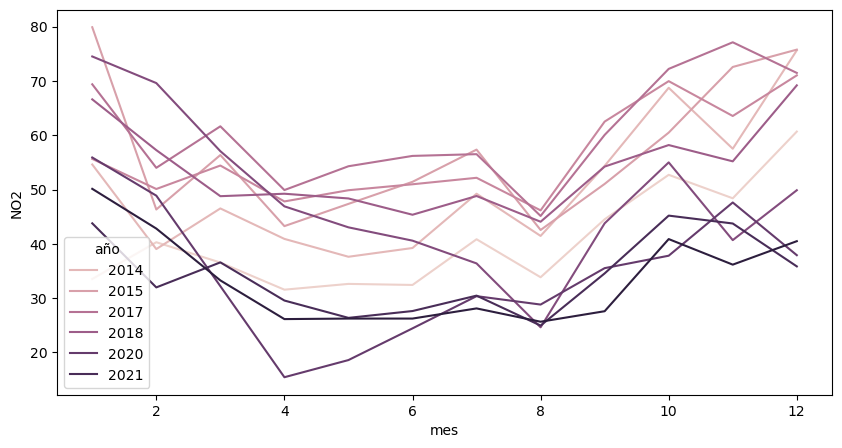

In [8]:
sns.lineplot(x = "mes", y = "NO2", hue = "año", data = df2);

### Estacionaridad

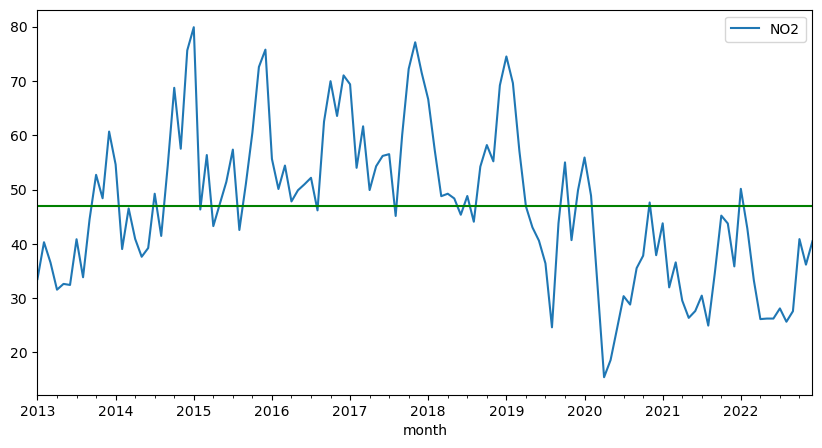

In [9]:
df.plot()
plt.axhline(df.NO2.mean(), c = "g");

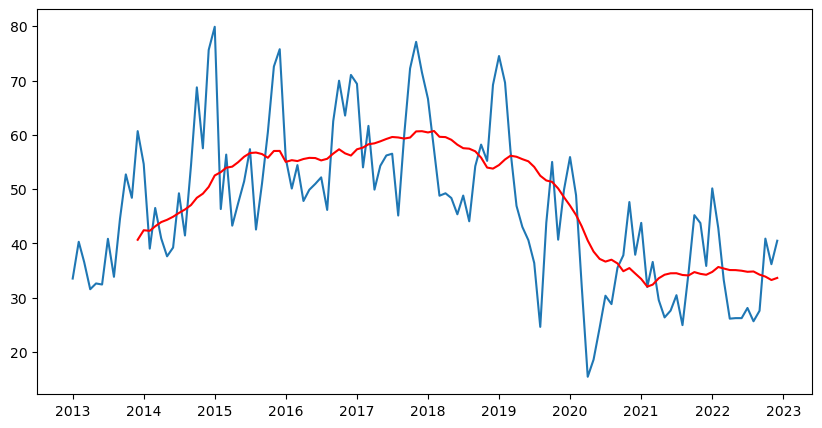

In [10]:
plt.plot(df["NO2"])
plt.plot(df.rolling(window= 12).mean(), c = "r");

In [11]:
df.head()

,NO2
month,
2013-01-01,33.516129
2013-02-01,40.290323
2013-03-01,36.548387
2013-04-01,31.548387
2013-05-01,32.612903


In [12]:
df2.head()

,NO2,año,mes
month,,,
2013-01-01,33.516129,2013,1
2013-02-01,40.290323,2013,2
2013-03-01,36.548387,2013,3
2013-04-01,31.548387,2013,4
2013-05-01,32.612903,2013,5


In [13]:
df3 = df.copy()

In [14]:
df3["year"] = df3.index.year
df3["month"] = df2.index.month
df3.head()

,NO2,year,month
month,,,
2013-01-01,33.516129,2013,1
2013-02-01,40.290323,2013,2
2013-03-01,36.548387,2013,3
2013-04-01,31.548387,2013,4
2013-05-01,32.612903,2013,5


In [15]:
df[df3["month"] == 12]

,NO2
month,
2013-12-01,60.677419
2014-12-01,75.645161
2015-12-01,75.774194
2016-12-01,71.032258
2017-12-01,71.483871
2018-12-01,69.193548
2019-12-01,49.870968
2020-12-01,37.903226
2021-12-01,35.838710


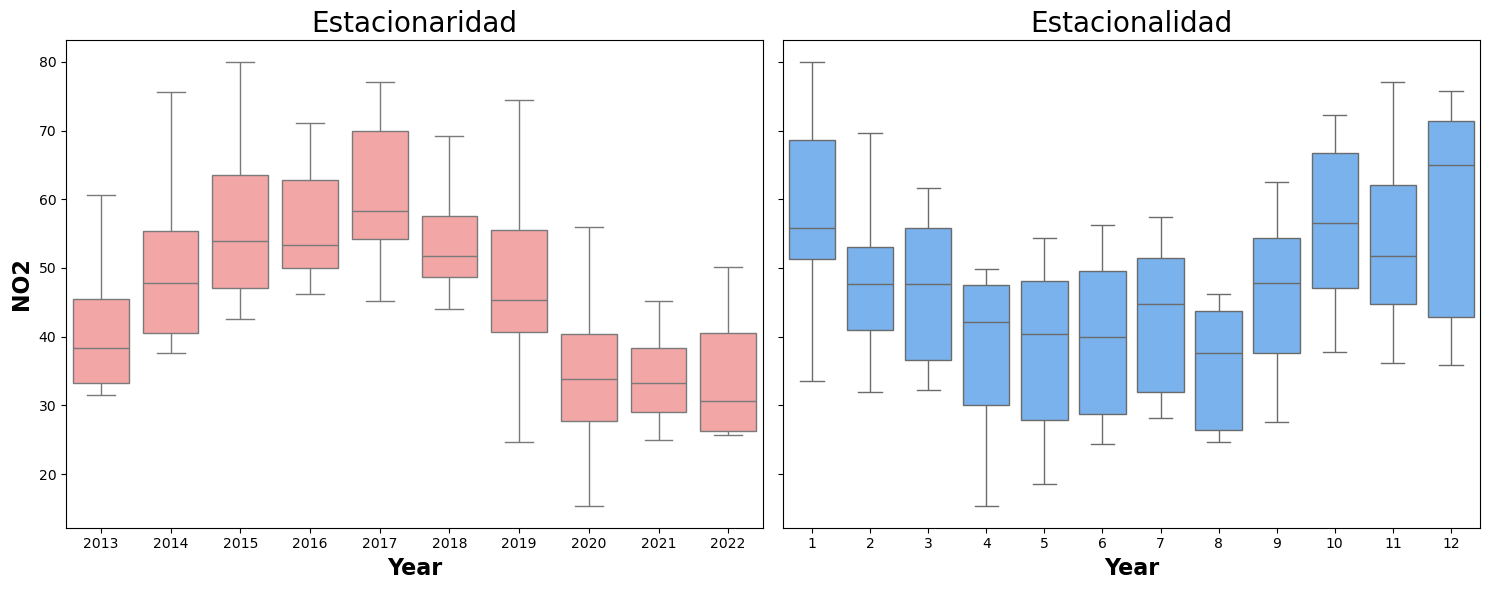

In [16]:
# Nos creamos una lista con las columnas de tiempo
tiempo = df3.columns.drop("NO2")

# Iniciamos los subplots
fig, ax = plt.subplots(nrows=1, ncols=len(tiempo), figsize=(15, 6), sharey=True)

# Nombres personalizados para los títulos
nombres = ["Estacionaridad", "Estacionalidad"]

# Colores bonitos para los boxplots
colores = ["#FF9999", "#66B2FF"]  # Puedes modificar estos códigos de colores

# Hacemos un loop para crear los boxplots para cada año
for i, col in enumerate(tiempo):
    sns.boxplot(data=df3, x=col, y="NO2", ax=ax[i], palette=[colores[i]])
    ax[i].set_title(nombres[i], fontsize=20, loc='center')
    ax[i].set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
    ax[i].set_ylabel('NO2', fontsize=16, fontdict=dict(weight='bold'))

plt.tight_layout()
plt.show()

No hay estacionaridad.

El de estacionalidad estudia todos los eneros, febreros,... de mis años muestra.

La aplicación de la estacionalidad (por ejemplo, a través de un modelo SARIMA con un parámetro estacional) sigue siendo relevante para comprender los patrones recurrentes en tus datos a lo largo del tiempo. Sin embargo, los desplazamientos o irregularidades en la mediana podrían indicar:

Cambios en los patrones estacionales: Las variaciones en la mediana podrían señalar cambios en los patrones estacionales a lo largo del tiempo. Esto puede requerir una exploración adicional para comprender si estas variaciones son anómalas o representan cambios genuinos en la estacionalidad.

Anomalías o eventos atípicos: La presencia de valores atípicos o eventos inusuales en los datos estacionales puede afectar la representación visual de la estacionalidad. Estos eventos pueden causar que la mediana no esté centrada en el boxplot.

En resumen, aunque la mediana desplazada en un boxplot puede indicar cierta variabilidad o cambios en los patrones estacionales, aún puedes aplicar el análisis estacional para comprender los ciclos recurrentes en tus datos. Sin embargo, es importante considerar las posibles anomalías o cambios en los datos que podrían estar afectando la representación visual de la estacionalidad.

### Test de Fuller

In [17]:
res = adfuller(df["NO2"])
res

(-0.3216276253520537,
 0.9223848680631204,
 12,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 742.3375568423282)

In [18]:
print("AD Fuller Stats", res[0])
print("p-value", res[1])
print("Critical values")

for k, v in res[4].items():
    print(k, round(v, 2))

AD Fuller Stats -0.3216276253520537
p-value 0.9223848680631204
Critical values
1% -3.49
5% -2.89
10% -2.58


*Datos no estacionarios. Su media y su varianza están en función del tiempo 🍋*

### Autocorrelación

In [19]:
for i in range(49):
    print(f"{i} mes Lag, {df['NO2'].autocorr(lag= i)}")

0 mes Lag, 1.0
1 mes Lag, 0.7900641691504245
2 mes Lag, 0.6354358796000251
3 mes Lag, 0.5214618271796957
4 mes Lag, 0.3570800353090171
5 mes Lag, 0.24572714667187803
6 mes Lag, 0.21286138748994118
7 mes Lag, 0.18231931627891185
8 mes Lag, 0.26711395190832377
9 mes Lag, 0.41506165507779075
10 mes Lag, 0.524708596333897
11 mes Lag, 0.611541943845334
12 mes Lag, 0.7191269697660836
13 mes Lag, 0.6119701219551309
14 mes Lag, 0.4837585581434771
15 mes Lag, 0.35047262666863477
16 mes Lag, 0.1741658134970513
17 mes Lag, 0.054189267583327566
18 mes Lag, 0.015654161775732395
19 mes Lag, -0.016877952914113977
20 mes Lag, 0.03367759235366405
21 mes Lag, 0.14197305117685777
22 mes Lag, 0.250293451376945
23 mes Lag, 0.3814847179659869
24 mes Lag, 0.49582251190536536
25 mes Lag, 0.40216956003431786
26 mes Lag, 0.2701184013203036
27 mes Lag, 0.14780628247575303
28 mes Lag, -0.03007760726918826
29 mes Lag, -0.19096184802696733
30 mes Lag, -0.26105153985818674
31 mes Lag, -0.2908281202401992
32 mes Lag,

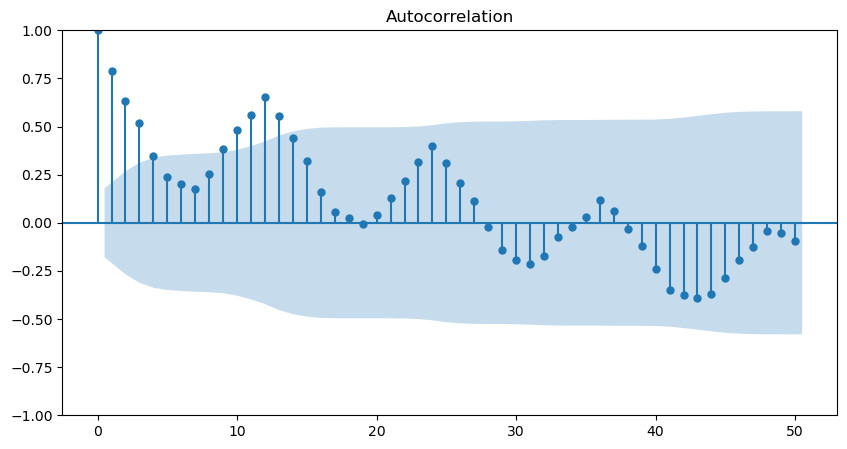

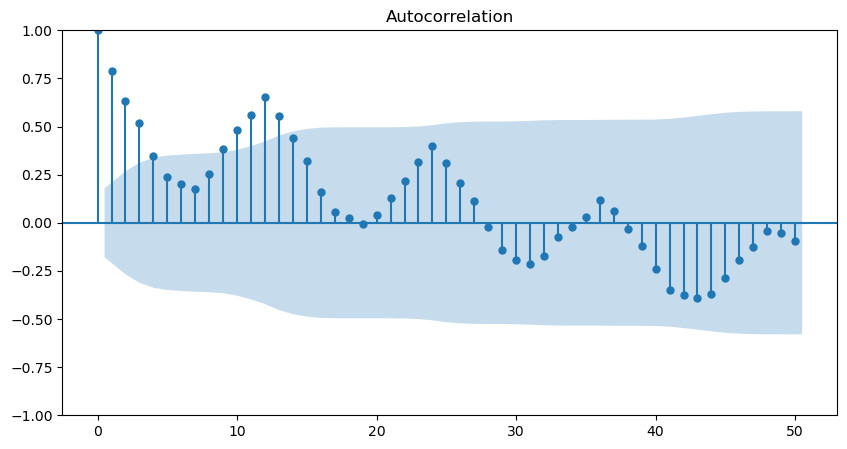

In [20]:
plot_acf(df, lags = 50)

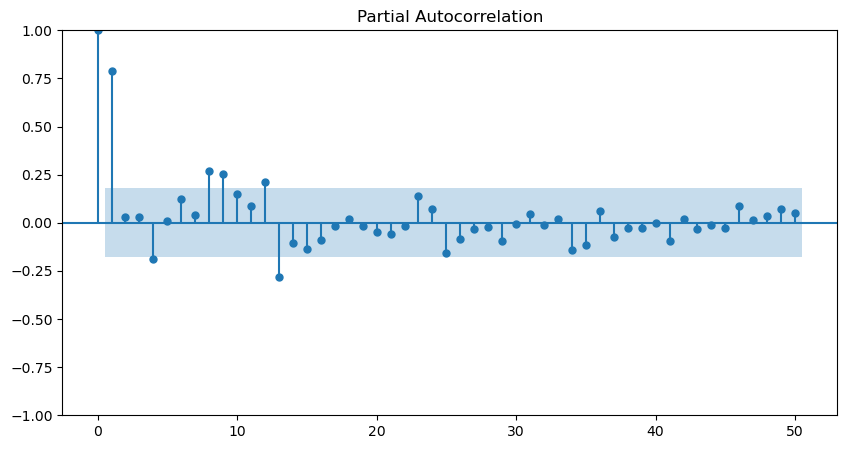

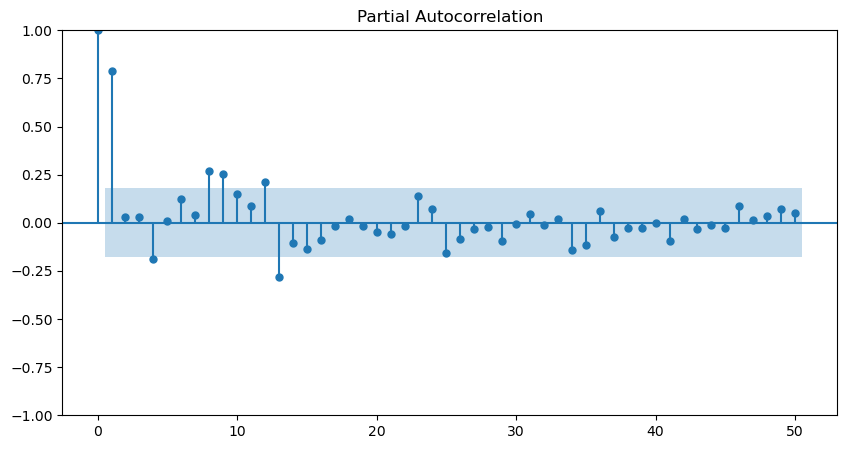

In [21]:
plot_pacf(df, lags = 50)

In [22]:
df.head()

,NO2
month,
2013-01-01,33.516129
2013-02-01,40.290323
2013-03-01,36.548387
2013-04-01,31.548387
2013-05-01,32.612903


In [23]:
df.shape

(120, 1)

In [24]:
df.isnull().sum()

NO2    0
dtype: int64

## SARIMA

In [25]:
y_test = df["NO2"][-30:]
y_train = df["NO2"][:-30]

In [26]:
ps = range(6)
ds = range(1,3)
qs = range(3)

parameters = list(product(ps,ds, qs))
print(parameters)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2)]


In [27]:
%%time
rmse = []
order = []
for p, d, q in tqdm(parameters):
    try:
        modelo=ARIMA(y_train, order=(p, d, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,d, q))
    except: 
        continue

  0%|          | 0/36 [00:00<?, ?it/s]C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_

C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 39%|███▉      | 14/36 [00:00<00:00, 28.71it/s]C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\

 72%|███████▏  | 26/36 [00:01<00:00, 16.32it/s]C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packag

CPU times: total: 1.11 s
Wall time: 2.31 s


In [28]:
# veamos los resultados de todos los modelos
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True)
results.head()

,RMSE,order
26,5.359663,"(4, 1, 2)"
31,7.447233,"(5, 1, 1)"
32,7.704618,"(5, 1, 2)"
25,7.712357,"(4, 1, 1)"
20,7.845580,"(3, 1, 2)"


In [29]:
%%time

modelo=SARIMAX(endog=y_train, 
               exog=None,
               #order=(4, 1, 5),  # modelo arima
               seasonal_order=(4, 1, 2, 12) # modelo sarima, estacionalidad es el ultimo
              ).fit(disp=False)
                     
pred=modelo.predict(len(y_train), len(df)-1)  

error=(pred-y_test).abs().sum()/len(pred) 
print ('Error mae: ', error)


res=pd.DataFrame({'real':y_test, 'pred':pred, 'error':pred-y_test})
res

C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ccior\anaconda3\envs\proyecto\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error mae:  8.262464600272349
CPU times: total: 1.33 s
Wall time: 5.61 s


,real,pred,error
2020-07-01,30.354839,29.708463,-0.646375
2020-08-01,28.806452,20.440182,-8.366270
2020-09-01,35.516129,34.676420,-0.839709
2020-10-01,37.806452,45.161698,7.355247
2020-11-01,47.612903,46.553057,-1.059846
2020-12-01,37.903226,54.350768,16.447542
2021-01-01,43.774194,48.761716,4.987522
2021-02-01,31.967742,45.867818,13.900076
2021-03-01,36.580645,37.347947,0.767302
2021-04-01,29.548387,29.186525,-0.361863


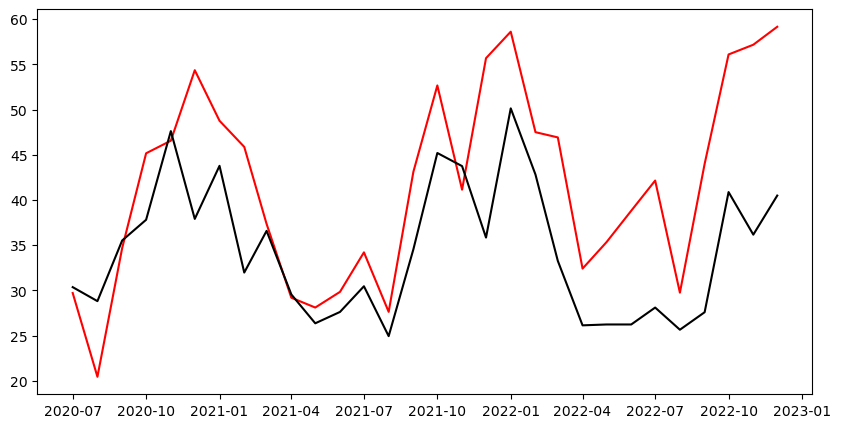

In [30]:
plt.plot(res["pred"], c = "r")
plt.plot(res["real"], c = "black");

In [31]:
pred["real_test"] = y_test

In [32]:
pred_año = pd.DataFrame(modelo.predict(start = len(df), end = len(df) + 9))
pred_año

,predicted_mean
2023-01-01,49.621517
2023-02-01,42.068706
2023-03-01,39.801188
2023-04-01,34.170388
2023-05-01,34.950119
2023-06-01,36.545515
2023-07-01,43.562485
2023-08-01,37.823602
2023-09-01,49.384167
2023-10-01,56.989713


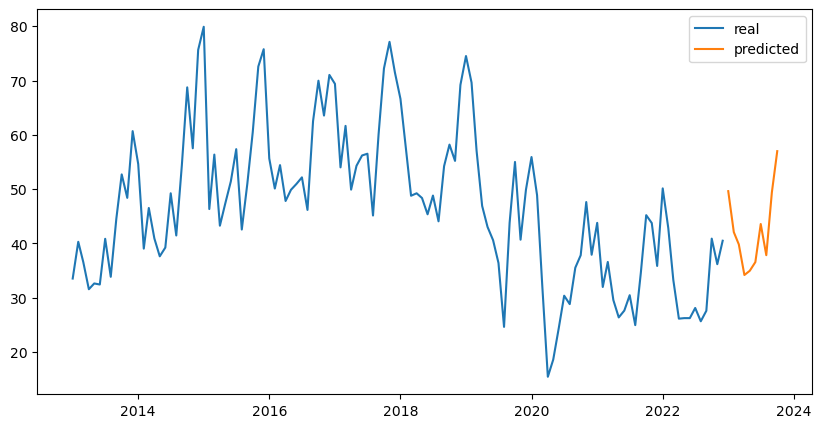

In [33]:
plt.plot(df)
plt.plot(pred_año)
plt.legend(["real", "predicted"]);

In [34]:
pred_año

,predicted_mean
2023-01-01,49.621517
2023-02-01,42.068706
2023-03-01,39.801188
2023-04-01,34.170388
2023-05-01,34.950119
2023-06-01,36.545515
2023-07-01,43.562485
2023-08-01,37.823602
2023-09-01,49.384167
2023-10-01,56.989713


## Datos reales 2023

In [35]:
df23 = pd.read_csv("../data/emisiones23.csv")

In [36]:
df23.head()

,Unnamed: 0,ESTACION,ANO,MES,NO2
0,0,4,2023,1,32.516129
1,1,4,2023,2,36.741935
2,2,4,2023,3,27.806452
3,3,4,2023,4,22.838710
4,4,4,2023,5,16.612903


In [37]:
df_8_23 = df23[df23["ESTACION"] == 8]
df_8_23

,Unnamed: 0,ESTACION,ANO,MES,NO2
10,10,8,2023,1,39.741935
11,11,8,2023,2,37.000000
12,12,8,2023,3,31.677419
13,13,8,2023,4,26.387097
14,14,8,2023,5,20.225806
15,15,8,2023,6,24.935484
16,16,8,2023,7,27.096774
17,17,8,2023,8,22.548387
18,18,8,2023,9,34.548387
19,19,8,2023,10,37.129032


In [38]:
len(df_8_23)

10

In [39]:
import sys
sys.path.append('../src')

from clean_support import NO2_clean, estacion_timeseries

In [40]:
estacion_timeseries(df_8_23)

,Unnamed: 0,NO2
month,,
2023-01-01,10,39.741935
2023-02-01,11,37.000000
2023-03-01,12,31.677419
2023-04-01,13,26.387097
2023-05-01,14,20.225806
2023-06-01,15,24.935484
2023-07-01,16,27.096774
2023-08-01,17,22.548387
2023-09-01,18,34.548387


In [41]:
df_8_23.drop("Unnamed: 0", axis=1, inplace=True)

In [42]:
len(pred_año)

10

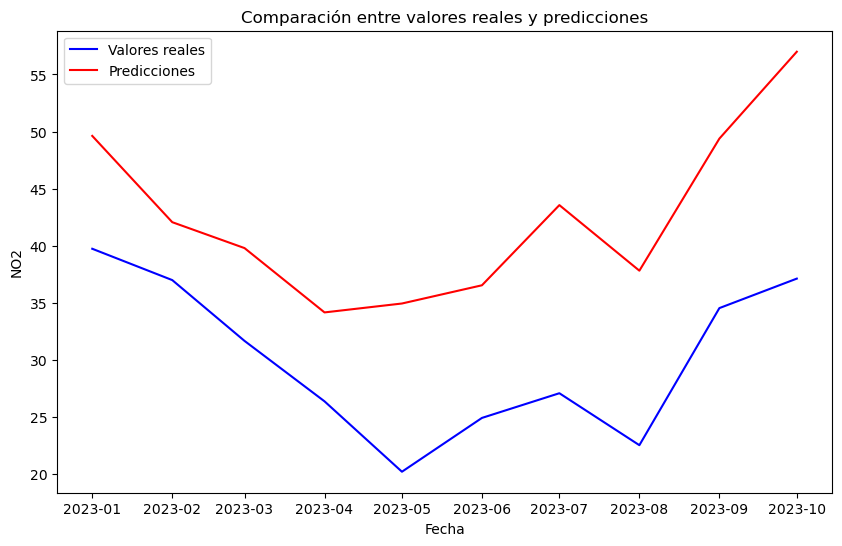

Error cuadrático medio (MSE): 172.0470144038783
Error absoluto medio (MAE): 12.362707579001839
Coeficiente de determinación (R^2): -3.133202194932454


In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suponiendo que tienes df_8_23 con los valores reales y pred_año con las predicciones

# Obtener datos reales y predicciones
real_data = df_8_23["NO2"]  # Valores reales hasta octubre de 2023
predicted_data = pred_año["predicted_mean"]
# Ajustar índices para coincidir
predicted_data.index = real_data.index[:len(predicted_data)]

# Graficar valores reales y predicciones
plt.figure(figsize=(10, 6))
plt.plot(real_data.index, real_data, label='Valores reales', color='blue')
plt.plot(predicted_data.index, predicted_data, label='Predicciones', color='red')
plt.xlabel('Fecha')
plt.ylabel('NO2')
plt.title('Comparación entre valores reales y predicciones')
plt.legend()
plt.show()

# Calcular métricas
mse = mean_squared_error(real_data, predicted_data)
mae = mean_absolute_error(real_data, predicted_data)
r2 = r2_score(real_data, predicted_data)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Coeficiente de determinación (R^2): {r2}")

Esta comparación de MAE puede indicar:
    
Cambios estacionales o tendencias: Si la naturaleza de los datos ha cambiado con el tiempo (por ejemplo, cambios en la estacionalidad, tendencias anómalas), esto podría afectar las predicciones actuales en comparación con las previas.